## 変分量子固有値ソルバー法 (実機を使ってRunTimeで実行)

Qiskit Runtimeという仕組みを使って、実機でVQEを実行します。

### 最初に以下の２つのセルを実行しておいてください。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.providers.ibmq import least_busy, IBMQAccountCredentialsNotFound
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import QuantumInstance
from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.gradients import Gradient
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import CG, GradientDescent

# ワークブック独自のモジュール
import sys
sys.path.append('/home/jovyan/qc-workbook-lecturenotes/ja')
from qc_workbook.utils import operational_backend

In [2]:
from qc_workbook.vqe import make_vqe_circuit
from qiskit_nature.runtime import VQEClient

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}
def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

n = 3   # 量子ビット数
nl = 2  # レイヤー数
npar = n*2*nl   # パラメータ数

vqe_circuit = make_vqe_circuit(n,nl,npar)

obs = Z ^ X ^ Y
optimizer = {'name': 'SPSA', 'maxiter': 100}
np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(vqe_circuit.num_parameters)
measurement_error_mitigation = True

IBMQ.load_account()
try:
    provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='qc-training22')
except IBMQProviderError:
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_list = provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                                   not x.configuration().simulator and x.status().operational==True)
backend = least_busy(backend_list)

runtime_vqe = VQEClient(ansatz=vqe_circuit,
                        optimizer=optimizer,
                        initial_point=initial_point,
                        provider=provider,
                        backend=backend,
                        shots=4096,
                        measurement_error_mitigation=measurement_error_mitigation,
                        callback=callback)
runtime_result = runtime_vqe.compute_minimum_eigenvalue(obs)

## 変分量子固有値ソルバー法 (シミュレータで実行)


In [3]:
from qiskit.circuit import ParameterVector
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import CG, GradientDescent

n = 3   # 量子ビット数
nl = 2  # レイヤー数
npar = n*2*nl   # パラメータ数

qc = QuantumCircuit(n)
param_list = ParameterVector('param_list',npar)
for i in range(nl):
    qc.ry(param_list[6*i], 0)
    qc.ry(param_list[6*i+1], 1)
    qc.ry(param_list[6*i+2], 2)
    qc.rz(param_list[6*i+3], 0)
    qc.rz(param_list[6*i+4], 1)
    qc.rz(param_list[6*i+5], 2)
    #qc.cnot(0, 1)
    #qc.cnot(1, 2)

obs = Z ^ X ^ Y

spsa = SPSA(maxiter=100)

random_seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend,
                                   shots=4096,
                                   seed_simulator=random_seed,
                                   seed_transpiler=random_seed,
                                   skip_qobj_validation=True)
# VQEアルゴリズムの実装
vqe_spsa = VQE(ansatz=qc, optimizer=spsa, quantum_instance=quantum_instance)
result_vqe_spsa = vqe_spsa.compute_minimum_eigenvalue(obs)

# 厳密解
ee = NumPyMinimumEigensolver()
result_ee = ee.compute_minimum_eigenvalue(obs)

print('Result:')
print(f'  Exact      = {result_ee.eigenvalue}')
print(f'  VQE(SPSA, Sim)  = {result_vqe_spsa.optimal_value}')

Result:
  Exact      = -1.0000000000000002
  VQE(SPSA, Sim)  = -0.9990234375


## 実機での実行が終了していたら

  VQE(SPSA, IBMQ) = -0.9941406250000001


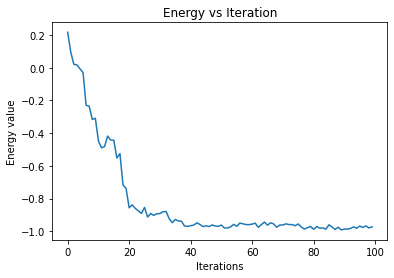

In [4]:
print(f'  VQE(SPSA, IBMQ) = {runtime_result.optimal_value}')

history = runtime_result.optimizer_history
loss = history['loss']
timestamps = history['time']
runtimes = np.concatenate(([0], np.diff(timestamps)))

plt.title("Energy vs Iteration")
plt.xlabel("Iterations")
plt.ylabel("Energy value")
plt.plot(range(len(runtimes)),loss)